In [81]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from time import time

from copy import deepcopy
from enum import Enum, auto

In [82]:
class GraphType(Enum):
    REPLY = auto()
    MENTION = auto()
    RETWEET = auto()

In [83]:
def create_subnetworks():
    """
    Creates subgraphs of the Higgs dataset with the full timestamps
    :return: nothing
    """
    activity_time_path = "../data/higgs-activity_time.txt"
    activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['target', 'source', 'time', 'type'])

    # create high resolution timestamped datasets
    reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
    mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
    retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

    activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']].to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    if isinstance(G, nx.DiGraph):
        return G.subgraph(max(nx.weakly_connected_components(G), key=len))
    else:
        return G.subgraph(max(nx.connected_components(G), key=len))

def build_df_from_graph(graph, bin_size=60*60):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'timestamp' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['time'] for d in graph_df['attribute']]
    # Start of the collection process on July 1st 2012 at 00:00
    min_t = 1341093600

    # Splitting into bins based on hour
    graph_df['timestamp'] = ((graph_df['timestamp'] - min_t) / bin_size).astype(int)
    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df = graph_df.sort_values(by=['timestamp'])
    graph_df.reset_index(drop=True, inplace=True)

    return graph_df


def build_social_network_df(graph):
    social_network_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Drop the 'attribute' column, which is no longer needed
    social_network_df.drop('attribute', axis=1, inplace=True)
    social_network_df = social_network_df.drop_duplicates()
    return social_network_df

In [165]:
def simulate_Twitter_spreading_start(informed_nodes, infected_nodes, social_network_df, graph_df, seed_node, graph_type):
    if graph_type is GraphType.REPLY:
        # if A replies B, then followers of A and B see the tweet
        informed_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] += 1
        informed_nodes[social_network_df[social_network_df['source'] == seed_node]['target']] += 1
        
        infected_nodes[social_network_df[graph_df['target'] == seed_node]['source']] = 1
        infected_nodes[social_network_df[graph_df['source'] == seed_node]['target']] = 1
    
    elif (graph_type is GraphType.MENTION) or (graph_type is GraphType.RETWEET):
        # if A mentions or retweets B, then only followers of A see the tweet
        informed_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] += 1
        infected_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] = 1

    else:
        raise Exception("Unexpected spreading process.")
        
    return infected_nodes, informed_nodes

def simulate_Twitter_spreading_continued(informed_nodes, infected_nodes, social_network_df, graph_df, current_edges, seed_node, graph_type):
    if graph_type is GraphType.REPLY:
        # if A replies B, then followers of A and B see the tweet
        susceptible_nodes_targets = current_edges['target']
        # Followers are targets
        susceptible_nodes_target_followers = social_network_df[social_network_df['target'].isin(current_edges['target'])]['target']
        susceptible_nodes_source_followers = social_network_df[social_network_df['target'].isin(current_edges['source'])]['target']
        
        # Get all susceptible nodes in this timestep
        susceptible_nodes = [susceptible_nodes_targets, susceptible_nodes_source_followers, susceptible_nodes_target_followers]
        susceptible_nodes = pd.concat(susceptible_nodes)
        
        infected_nodes[susceptible_nodes] = 1
        informed_nodes[susceptible_nodes] += 1

    elif (graph_type is GraphType.MENTION) or (graph_type is GraphType.RETWEET):
        # if A mentions or retweets B, then only followers of A see the tweet
        susceptible_nodes_targets = current_edges['target']
        # Followers are targets
        susceptible_nodes_source_followers = social_network_df[social_network_df['target'].isin(current_edges['source'])]['target']
        
        # Get all susceptible nodes in this timestep
        susceptible_nodes = [susceptible_nodes_targets, susceptible_nodes_source_followers]
        susceptible_nodes = pd.concat(susceptible_nodes)
        
        infected_nodes[susceptible_nodes] = 1
        informed_nodes[susceptible_nodes] += 1
    
    else:
        raise Exception("Unexpected spreading process.")
    
    print(infected_nodes.sum())
    return infected_nodes, informed_nodes

In [179]:
def simulate_spreading(graph_df, social_network_df, seed_node, start_timestamp,
                       end_timestamp, graph_type, name="G", plot=True):
    
    number_of_component_nodes = len(set(graph_df['target']).union(set(graph_df['source'])))
    number_of_total_nodes = len(set(social_network_df['target']).union(set(social_network_df['source'])))
    
    # Initialize arrays to store all nodes in the information spreading process
    graph_nodes = np.zeros(max(social_network_df['source'].max(),
                               social_network_df['target'].max()) + 1)
    
    # Infected nodes consider only first-time infections
    infected_nodes = deepcopy(graph_nodes)
    # Informed nodes consider any time a node is part of the spreading process
    informed_nodes = deepcopy(graph_nodes)

    # Set all initial values to 0
    graph_nodes[np.concatenate((np.array(graph_df['source'].unique()),
                                np.array(graph_df['target'].unique())))] = 0
    
    # Consider the start time of the spreading process as the first interaction of the seed node
    spreading_start_time = graph_df[graph_df['source'] == seed_node]['timestamp'].min()
    
    infected_nodes_time = [infected_nodes.sum() / number_of_component_nodes]
    informed_nodes_time = [informed_nodes.sum() / number_of_total_nodes]
    
    # Iterate over all timestamps
    for timestamp in range(start_timestamp, end_timestamp + 1):
        
        # If we are before the start time of interest, go to the next iteration
        if timestamp < spreading_start_time:
            continue
        
        # If we are at the start time of interest, start spreading
        if timestamp == spreading_start_time:
            # seed_node gets infected and informed
            infected_nodes[seed_node] = 1
            informed_nodes[seed_node] += 1

            continue
            
        print(f'Graph: {name} Timestamp: {timestamp}/{end_timestamp}', end='\r')
        
        # For each timestamp get the edges that were created in that timestamp
        current_edges = graph_df[graph_df['timestamp'] == timestamp]
        
        if graph_type is GraphType.REPLY:
            # if A replies B, then followers of A and B see the tweet
            susceptible_nodes_targets = current_edges['target']
            # Followers are targets
            susceptible_nodes_target_followers = social_network_df[social_network_df['target'].isin(current_edges['target'])]['target']
            susceptible_nodes_source_followers = social_network_df[social_network_df['target'].isin(current_edges['source'])]['target']

            # Get all susceptible nodes in this timestep
            susceptible_nodes = [susceptible_nodes_targets, susceptible_nodes_source_followers, susceptible_nodes_target_followers]
            susceptible_nodes = pd.concat(susceptible_nodes)

            infected_nodes[susceptible_nodes] = 1
            informed_nodes[susceptible_nodes] += 1

        elif (graph_type is GraphType.MENTION) or (graph_type is GraphType.RETWEET):
            # if A mentions or retweets B, then only followers of A see the tweet
            susceptible_nodes_targets = current_edges['target']
            # Followers are targets
            susceptible_nodes_source_followers = social_network_df[social_network_df['target'].isin(current_edges['source'])]['target']

            # Get all susceptible nodes in this timestep
            susceptible_nodes = [susceptible_nodes_targets, susceptible_nodes_source_followers]
            susceptible_nodes = pd.concat(susceptible_nodes)

            infected_nodes[susceptible_nodes] = 1
            informed_nodes[susceptible_nodes] += 1

        else:
            raise Exception("Unexpected spreading process.")
    
#         infected_nodes *= graph_nodes

        # Add the infected and informed nodes to the lists
        infected_nodes_time.append(infected_nodes.sum() / number_of_component_nodes)
        informed_nodes_time.append(informed_nodes.sum())

    # Do the plotting if required
    if plot:
        plt.plot(np.arange(start_timestamp, end_timestamp),
                 infected_nodes_time, label=f"{name} infected nodes", alpha=0.8)
        plt.legend()
        plt.show()
        
        plt.plot(np.arange(start_timestamp, end_timestamp),
                 informed_nodes_time, label=f"{name} informed nodes", alpha=0.8)
        plt.legend()
        plt.show()
        
        residuals = (infected_nodes_time / max(infected_nodes_time)) - (informed_nodes_time / max(informed_nodes_time))
        plt.plot(np.arange(start_timestamp, end_timestamp),
                 residuals, label=f"{name} residuals", alpha=0.8)
        plt.legend()
        plt.show()
        
    return infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time

def get_start_end_combined(subgraph_reply_df, subgraph_mention_df, subgraph_retweet_df):
    start_timestamp_reply = min(subgraph_reply_df['timestamp'])
    start_timestamp_mention = min(subgraph_mention_df['timestamp'])
    start_timestamp_retweet = min(subgraph_retweet_df['timestamp'])
    end_timestamp_reply = max(subgraph_reply_df['timestamp'])
    end_timestamp_mention = max(subgraph_mention_df['timestamp'])
    end_timestamp_retweet = max(subgraph_retweet_df['timestamp'])

    start_timestamp = min(start_timestamp_reply, start_timestamp_mention, start_timestamp_retweet)
    end_timestamp = max(end_timestamp_reply, end_timestamp_mention, end_timestamp_retweet)
    return start_timestamp, end_timestamp

In [87]:
create_subnetworks()

In [88]:
G_reply = nx.read_edgelist("../output/reply_timestamps.edgelist", nodetype=int, data=(('time',int),), create_using=nx.DiGraph)
G_mention = nx.read_edgelist("../output/mention_timestamps.edgelist", nodetype=int, data=(('time', int),),  create_using=nx.DiGraph)
G_retweet = nx.read_edgelist("../output/retweet_timestamps.edgelist", nodetype=int, data=(('time', int),), create_using=nx.DiGraph)
G_social = nx.read_edgelist("../data/higgs-social_network.edgelist", nodetype=int, create_using=nx.DiGraph)

G_reply_lcc = largest_connected_component(G_reply)
G_mention_lcc = largest_connected_component(G_mention)
G_retweet_lcc = largest_connected_component(G_retweet)

In [89]:
G_reply_lcc_df = build_df_from_graph(G_reply_lcc)
G_mention_lcc_df = build_df_from_graph(G_mention_lcc)
G_retweet_lcc_df = build_df_from_graph(G_retweet_lcc)

In [90]:
G_reply_df = build_df_from_graph(G_reply)
G_mention_df = build_df_from_graph(G_mention)
G_retweet_df = build_df_from_graph(G_retweet)

In [91]:
G_social_df = build_social_network_df(G_social)

In [92]:
print(G_retweet_lcc)
print(G_mention_lcc)
print(G_reply_lcc)
print(G_social)

DiGraph with 223833 nodes and 308596 edges
DiGraph with 91606 nodes and 132068 edges
DiGraph with 12839 nodes and 14944 edges
DiGraph with 456626 nodes and 14855842 edges


In [94]:
def get_subgraph(G, max_n_of_nodes=5000, is_seed_node_most_connected=True, seed = None):
    """
    Returns a subgraph of G with k nodes generated by BFS from a seed node
    :param G: graph
    :param k: number of nodes in the subgraph
    :param is_seed_node_most_connected: whether the seed node is the most connected node or a random node
    :param seed: seed node, random if None
    :return: subgraph
    """
    if max_n_of_nodes is None:
        max_n_of_nodes = G.number_of_nodes() // 5

    if seed:
        seed_node = seed
    elif is_seed_node_most_connected:
        seed_node = max(G.degree(), key=lambda x: x[1])[0]
    else:
        # Choosing a random node does not guarantee getting a subgraph of the desired size
        seed_node = random.choice(list(G.nodes()))
    # Initialize a queue for BFS and a set for visited nodes
    queue = [seed_node]
    visited = set([seed_node])
    # Initialize the subgraph with the starting node
    subgraph = nx.Graph()
    subgraph.add_node(seed_node)
    
    # While the subgraph has fewer than n nodes and the queue is not empty
    while len(subgraph) < max_n_of_nodes and queue:
        # Get the next node from the queue
        curr_node = queue.pop(0)
        # Add its neighbors that have not been visited to the queue and the subgraph
        for neighbor in G.neighbors(curr_node):
            if neighbor not in visited:
                if len(subgraph) >= max_n_of_nodes:
                    break
                visited.add(neighbor)
                subgraph.add_node(neighbor)
                subgraph.add_edge(curr_node, neighbor, day=G[curr_node][neighbor]["time"])
                queue.append(neighbor)
    
    # Add all edges between sampled nodes which existed in the original graph
    for u, v, a in G.edges(data=True):
        if (u in subgraph) and (v in subgraph):
            subgraph.add_edge(u, v, time=a["time"])
    
    return subgraph

In [95]:
# Start spreading from the node with the maximal out_degree in each of the networks
max_degree_reply = max(G_reply.out_degree(), key=lambda x: x[1])[0]
print(f" Seed {G_reply.out_degree(max_degree_reply)} for REPLY network")

max_degree_retweet = max(G_retweet.out_degree(), key=lambda x: x[1])[0]
print(f" Seed {G_retweet.out_degree(max_degree_retweet)} for RETWEET network")

max_degree_mention = max(G_mention.out_degree(), key=lambda x: x[1])[0]
print(f" Seed {G_mention.out_degree(max_degree_mention)} for MENTION network")

# Get the subgraph of the node with the maximum average degree
subgraph_reply = get_subgraph(G_reply, max_n_of_nodes=5000, seed=max_degree_reply)
print(subgraph_reply)

subgraph_mention = get_subgraph(G_mention, max_n_of_nodes=5000, seed=max_degree_mention)
print(subgraph_mention)

subgraph_retweet = get_subgraph(G_retweet, max_n_of_nodes=5000, seed=max_degree_retweet)
print(subgraph_retweet)

 Seed 1206 for REPLY network
 Seed 14060 for RETWEET network
 Seed 11953 for MENTION network
Graph with 3112 nodes and 3437 edges
Graph with 5000 nodes and 8323 edges
Graph with 5000 nodes and 6712 edges


In [96]:
def get_nodes_by_centrality(network, n_nodes, start=0, metric='degree_out'):
    if metric == 'degree_out':
        centr = G_reply.out_degree()
    if metric == 'degree_in':
        centr = G_reply.in_degree()
    if metric == 'eigen':
        centr = nx.eigenvector_centrality(G_reply)
    return [v[0] for v in sorted(centr, key=lambda x: -x[1])][start:start + n_nodes]

In [97]:
n_nodes = 50
metric = 'degree_in'

max_degree_reply = get_nodes_by_centrality(G_reply, n_nodes)
max_degree_retweet = get_nodes_by_centrality(G_retweet, n_nodes)
max_degree_mention = get_nodes_by_centrality(G_mention, n_nodes)

print(max_degree_reply)

[677, 88, 220, 3549, 317, 349, 1988, 7690, 3369, 16460, 2177, 4368, 2014, 4259, 6940, 5245, 216, 327, 12281, 3998, 9964, 13808, 7962, 1880, 2280, 1574, 511, 14454, 4446, 9021, 16188, 36436, 68278, 5335, 2941, 2353, 3419, 503, 459, 245, 2288, 2417, 408, 16527, 122488, 352, 1276, 13854, 11036, 2347]


In [98]:
start_timestamp, end_timestamp = get_start_end_combined(G_reply_lcc_df, G_mention_lcc_df, G_retweet_lcc_df)
print(start_timestamp)
print(end_timestamp)

2
169


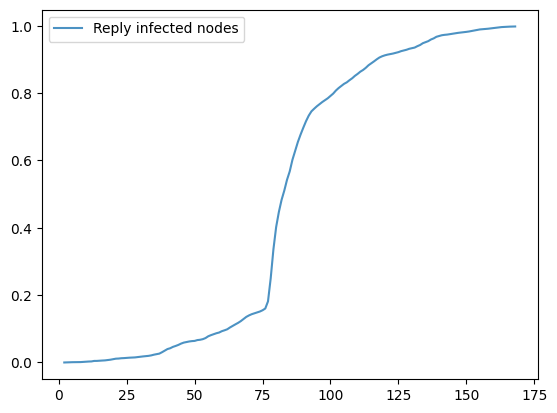

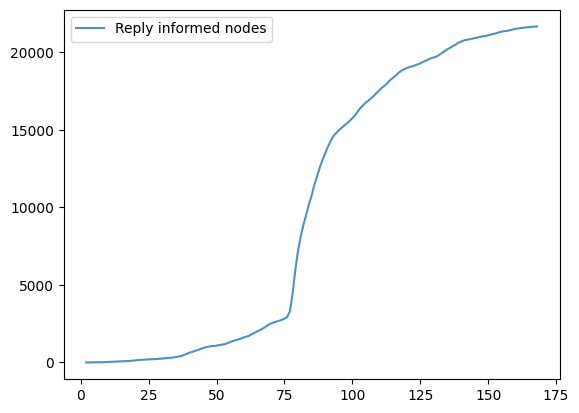

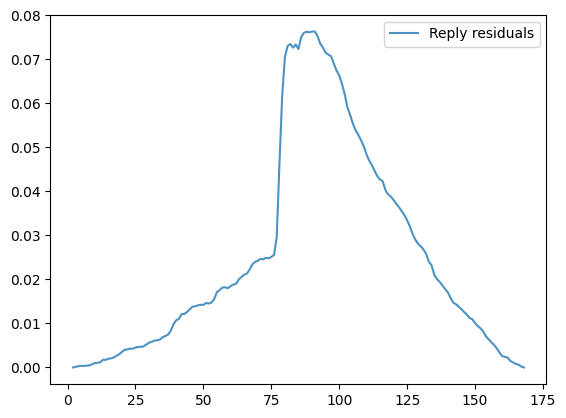

CPU times: total: 1min 15s
Wall time: 1min 15s


In [181]:
%%time
infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(G_reply_lcc_df, \
            G_social_df, max_degree_reply[0], start_timestamp, end_timestamp, GraphType.REPLY, name="Reply", plot=True)

In [13]:
def simulate_spreading_n_nodes(graph_df, social_network_df, seed_nodes, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name="name_not_given", plot=True):
    
    infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n = [], [], [], []
    
    for node in seed_nodes:
        infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(\
                graph_df, social_network_df, node, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name=name, plot=plot)
        
        infected_nodes_n.append(infected_nodes)
        informed_nodes_n.append(informed_nodes)
        infected_nodes_time_n.append(infected_nodes_time)
        informed_nodes_time_n.append(informed_nodes_time)
        
    return infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n

In [14]:
def cum_to_diff(time):
    return np.array(time[1:]) - np.array(time[:-1])

In [28]:
def get_crosscorr(proc_n_1, proc_n_2):
    return [np.correlate(cum_to_diff(proc_1), cum_to_diff(proc_2), 'full') for proc_1, proc_2 in zip(proc_n_1, proc_n_2)]

In [ ]:
_, _, infected_nodes_time_rep, informed_nodes_time_rep = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_degree_reply, start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=False)
_, _, infected_nodes_time_ret, informed_nodes_time_ret = simulate_spreading_n_nodes(G_retweet_lcc_df, G_social_df, max_degree_retweet, start_timestamp, end_timestamp, len(G_retweet_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=False)

In [17]:
infected_nodes_time_rep, informed_nodes_time_rep = np.array(infected_nodes_time_rep), np.array(informed_nodes_time_rep)
infected_nodes_time_ret, informed_nodes_time_ret = np.array(infected_nodes_time_ret), np.array(informed_nodes_time_ret)

In [124]:
min_x = 
max_x = -1
corr_n = get_crosscorr(np.array(infected_nodes_time_rep)[:, min_x:max_x], np.array(infected_nodes_time_ret)[:, min_x:max_x])

In [125]:
corr_n = np.nan_to_num([c/np.max(c) for c in corr_n[:]])

C:\Users\drobi\AppData\Local\Temp\ipykernel_20668\1895130831.py:1: RuntimeWarning: invalid value encountered in true_divide
  corr_n = np.nan_to_num([c/np.max(c) for c in corr_n[:]])


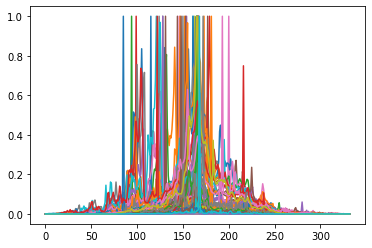

In [126]:
[plt.plot(c) for c in corr_n[:]]
plt.show()

In [127]:
corr = np.mean(corr_n[:], axis=0)

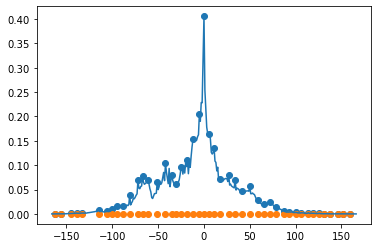

In [128]:
d = len(corr) // 2
plt.plot(np.arange(-d, d + 1), corr)
peaks = find_peaks(corr, distance=5)[0]
plt.scatter(peaks - d, corr[peaks])
plt.scatter(peaks - d, [0]*len(peaks))
# plt.yscale('log')

In [130]:
sorted([(x, y) for x, y in zip(peaks - d, corr[peaks])], key=lambda x: -x[1])

[(0, 0.4056515588928507),
 (-5, 0.205613609475602),
 (6, 0.1629966299896914),
 (-12, 0.1530683164550091),
 (11, 0.13617227407348984),
 (-18, 0.11014866022744513),
 (-42, 0.10362229954018909),
 (-25, 0.09537619135126746),
 (-35, 0.08007298754268413),
 (27, 0.08006576813082779),
 (-67, 0.07798807661299974),
 (17, 0.07259546329981703),
 (34, 0.07052978285387285),
 (-61, 0.06898613000130313),
 (-72, 0.06869277788901326),
 (-51, 0.06621984068486948),
 (-30, 0.06198322338657427),
 (50, 0.05656209691981884),
 (41, 0.046897960981816755),
 (-81, 0.038799425792134364),
 (59, 0.028725884550013955),
 (72, 0.024118030769731544),
 (65, 0.0213139820320495),
 (-95, 0.01719491965076581),
 (-88, 0.01571700632867455),
 (79, 0.01425370236485623),
 (-100, 0.009469632153916977),
 (-115, 0.00756052747483611),
 (87, 0.0059863130242768835),
 (-106, 0.0051650874573547865),
 (93, 0.004425782601683096),
 (100, 0.00319017840621178),
 (114, 0.002409534621036314),
 (106, 0.0024057459676533996),
 (-133, 0.00192413076

In [ ]:
[plt.plot(i) for i in informed_nodes_time_rep[:, cutoff:]]

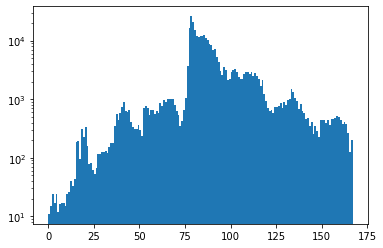

In [129]:
plt.hist(G_retweet_df['timestamp'], bins=167)
plt.yscale('log')